In [1]:
import sys
sys.path.append('..')
import os
import shutil
import torch

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy
%matplotlib notebook

from data import *
from model import Loop
from utils import generate_merlin_wav

from torch.autograd import Variable
from IPython.display import Audio

def plot(data, labels, dict_file):
    labels_dict = dict_file
    labels_dict = {v: k for k, v in labels_dict.iteritems()}
    labels = [labels_dict[x].decode('latin-1') for x in labels]

    axarr = plt.subplot()
    axarr.imshow(data.T, aspect='auto', origin='lower', interpolation='nearest', cmap=cm.viridis)
    axarr.set_yticks(numpy.arange(0, len(data.T)))
    axarr.set_yticklabels(labels, rotation=90)

In [2]:
import copy
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_path = os.path.abspath('../data/vctk/numpy_features')
norm_info = os.path.abspath('../data/vctk/norm_info/norm.dat')
    
train_dataset = NpzFolder(data_path)
valid_dataset = NpzFolder(data_path + '_valid')

In [4]:
torch.cuda.current_device()

0L

In [5]:
torch.cuda.set_device(-1)

In [6]:
#os.chdir('../')

In [7]:
os.getcwd()

'/home/ubuntu/loop/notebooks'

In [8]:
# use my model
checkpoint = '../checkpoints/vctk'
weights = torch.load(checkpoint + '/bestmodel.pth')

In [9]:
# use downloaded model
checkpoint = '../models/vctk'
weights = torch.load(checkpoint + '/bestmodel.pth', map_location={'cuda:1' : 'cuda:0', 'cuda:2' : 'cuda:0'}) #https://github.com/facebookresearch/SentEval/issues/3

In [10]:
# set up model using saved weights
args = torch.load(checkpoint + '/args.pth', map_location={'cuda:1' : 'cuda:0', 'cuda:2' : 'cuda:0'})
opt = args[0]
opt.noise = 0

model = Loop(opt)
model.load_state_dict(weights)
model.cuda();
model.eval();

In [11]:
# define test example
ID = 5
txt, feat, _ = valid_dataset[14]

txt = Variable(txt.unsqueeze(1), volatile=True).cuda()
feat = Variable(feat.unsqueeze(1), volatile=True).cuda()
spkr = Variable(torch.LongTensor([ID]), volatile=True).cuda()

# run model
out, attn = model([txt, spkr], feat)

In [12]:
# uses 'out' features to synthesize the sample
generate_merlin_wav(out.data.cpu().numpy(), "/tmp/gen", file_basename='test',
                    norm_info_file=norm_info, do_post_filtering=True)
Audio('/tmp/gen/test.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.


## Synthesizing Voice from Original Features
i.e. the features calculated from the original .wav sample

In [13]:
# uses feat
generate_merlin_wav(feat.data.cpu().numpy(), "/tmp/gen", file_basename='test',
                    norm_info_file=norm_info, do_post_filtering=True)
Audio('/tmp/gen/test.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.


## Attention Plot

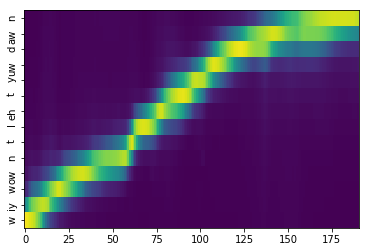

In [23]:
plot(attn.squeeze().data.cpu().numpy(), txt[:,0].squeeze().data.tolist(), valid_dataset.dict)

In [18]:
attn.squeeze().data.cpu().numpy().shape

(191, 14)

In [21]:
txt[:,0].squeeze().data.tolist()

[39, 19, 39, 26, 24, 34, 22, 11, 34, 40, 37, 9, 4, 24]

## Investigating Features

In [20]:
feat.size()

torch.Size([191, 1, 63])

In [21]:
out.size() # how does out know to have 530 timesteps?

torch.Size([191, 1, 63])

In [22]:
test = copy.deepcopy(out)

In [23]:
test = test[:400, :, :]

In [24]:
test.size()

torch.Size([191, 1, 63])

In [25]:
generate_merlin_wav(test.data.cpu().numpy(), "/tmp/gen", file_basename='test',
                    norm_info_file=norm_info, do_post_filtering=True)
Audio('/tmp/gen/test.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.


In [27]:
idx = 180
out[idx, :, :]

Variable containing:

Columns 0 to 9 
 0.1093  0.2346 -0.9944 -1.0805  1.1354  0.3887 -1.1580 -0.5611 -1.3048 -1.1468

Columns 10 to 19 
-0.8064 -1.8187  2.1407  0.5700 -1.7034  2.3335 -0.3876  0.0725  0.3525  0.2714

Columns 20 to 29 
 0.5037 -0.4937  0.6204 -0.1604  0.1157  0.2848 -0.2436  0.1120 -0.5455  0.8370

Columns 30 to 39 
-0.4362  0.4755 -0.7003  0.3933  0.0956 -0.0738  0.0546 -0.4201  0.5983 -0.2411

Columns 40 to 49 
-0.1080 -0.0191  0.4763 -0.5252  0.0726  0.3019 -0.1230 -0.3188  0.3485  0.0349

Columns 50 to 59 
-0.4867  0.3260  0.1755 -0.6103  0.5306 -0.2065  0.1109 -0.4392  0.8265 -0.8353

Columns 60 to 62 
-1.0274  1.2141  0.9292
[torch.cuda.FloatTensor of size 1x63 (GPU 0)]

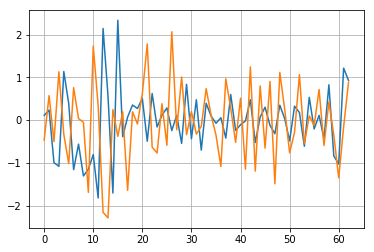

In [28]:
plt.plot(out[idx,0,:].data.cpu().numpy())#
plt.plot(feat[idx,0,:].data.cpu().numpy())
plt.grid(True)


## Manually modify features in the original

In [81]:
hack = copy.deepcopy(feat.data.cpu().numpy())
#feat[:,:,1] = 0

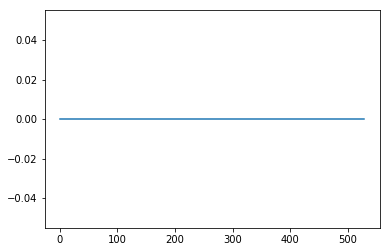

In [122]:
plt.plot(hack[:,:,1])
hack[:,:,:] = 0

In [123]:
generate_merlin_wav(hack, "/tmp/gen", file_basename='test',
                    norm_info_file=norm_info, do_post_filtering=True)
Audio('/tmp/gen/test.wav', autoplay=True)

{'mgc': 0, 'vuv': 60, 'lf0': 61, 'bap': 62}
complete test.wav.


In [121]:
hack

array([[[-2.62403178,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-2.23841238,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-1.84489024,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       ..., 
       [[-0.7304638 ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.78042847,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.81558406,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)